In [2]:
from PIL import Image
import numpy as np
import cv2
import selectivesearch
from skimage.segmentation import felzenszwalb
import matplotlib.pyplot as plt

In [3]:
# 讀取圖片
image_path = 'memememe.jpg'
image = Image.open(image_path)
image_np = np.array(image)

# 轉換為OpenCV格式
image_cv = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

In [4]:
#建立使用matplotlib繪製圖片的函式，傳入參數為不定個數...的圖片以及相對應的圖片title
def visualize_output(*images_titles):
    """
    使用matplotlib繪製圖片的函式，傳入參數為不定個數的圖片以及相對應的圖片title。
    
    :param images_titles: 不定個數的圖片和標題，格式為 (image, title)
    """
    num_images = len(images_titles)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    
    if num_images == 1:
        axes = [axes]
    
    for ax, (image, title) in zip(axes, images_titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    
    plt.show()

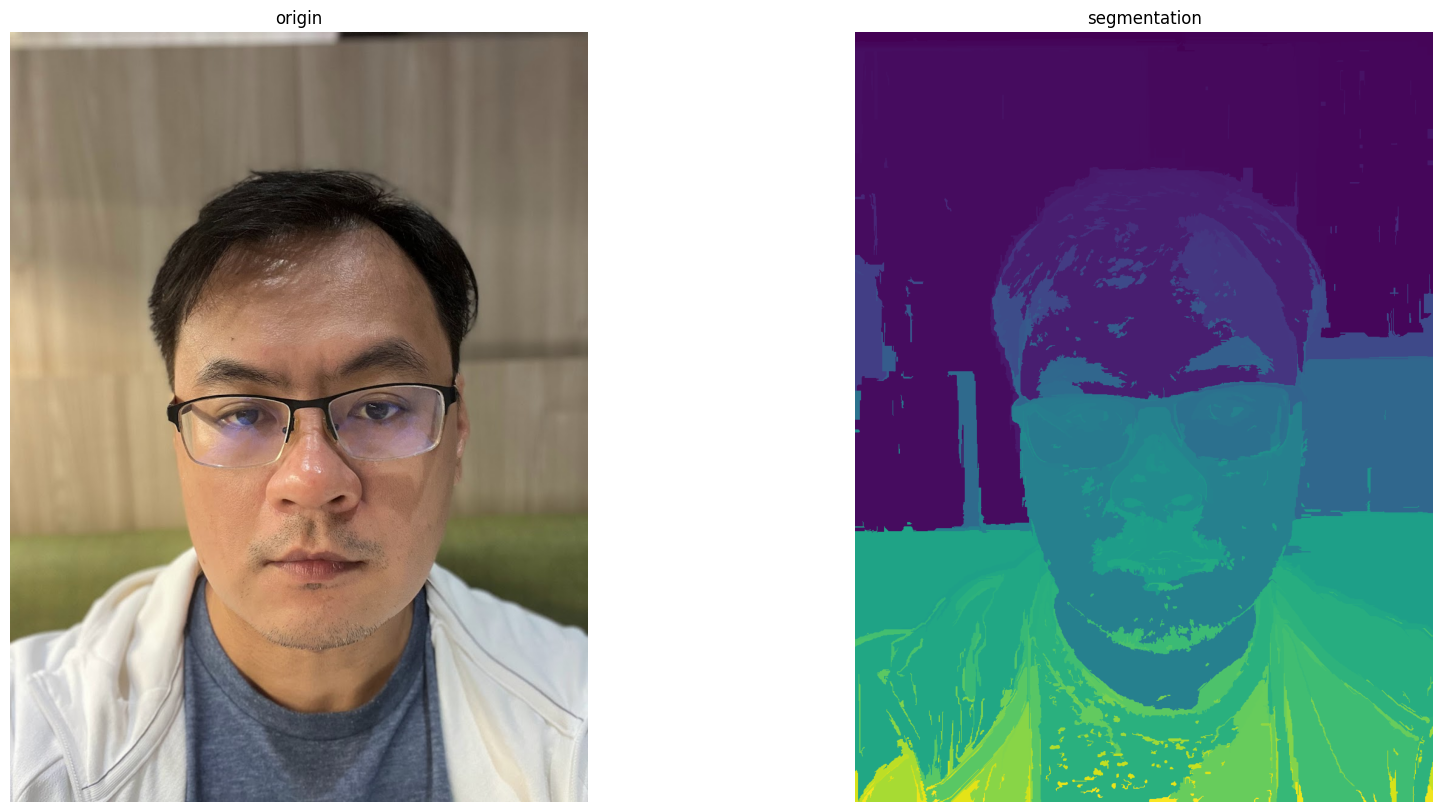

In [7]:
segments_fz = felzenszwalb(image, scale=200)
visualize_output((image, 'origin'), (segments_fz, 'segmentation'))

/Users/leonjye/.local/share/virtualenvs/CV_Code-g2gMwIvA/lib/python3.13/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


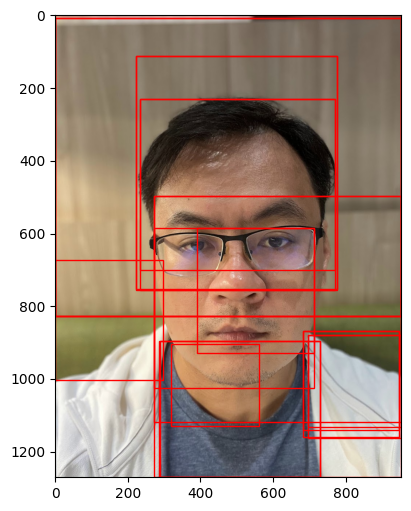

In [8]:
# 執行Selective Search
img_lbl, regions = selectivesearch.selective_search(image_cv, scale=500, sigma=0.9, min_size=10)

# 過濾候選區域
candidates = set()
for r in regions:
    # 排除小區域
    if r['rect'] in candidates:
        continue
    if r['size'] < 2000:
        continue
    # 排除長寬比不合理的區域
    x, y, w, h = r['rect']
    if w / h > 1.2 or h / w > 1.2:
        continue
    candidates.add(r['rect'])

# 繪製候選區域
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(image_np)

for x, y, w, h in candidates:
    rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

plt.show()

現在我們已經瞭解了區域提案的生成，但有一個問題仍未得到解答。

如何利用區域提案進行物件檢測和定位？

與感興趣圖像中物件的位置（真實值）相交較高的區域建議被標記為包含該對象的區域，而交集較低的區域建議
被標記為背景。(intersection over union, IOU)

## 什麼是 Non-max suppression (非最大抑制)
想像一下：生成了多個區域建議（region proposals），並且彼此之間明顯重疊。從本質上講，所有預測的邊界框座標（區
域建議的偏移量）都彼此顯著重疊，該如何在眾多區域建議中識別，包含物件的框以及「將丟棄的框」？

在這種情況下，非極大值抑制會派上用場。
Non-max 是指沒有最高概率包含物件的框，而 suppression 是指我們丟棄這些框。

在非極大值抑制中，我們確定包含物件的可能性最高的邊界框，並丟棄IoU低於特定閾值的所有其他邊界框，該框顯示包含物件的概率最高。
在 PyTorch 中，使用 torchvision.ops 模組中的 nms 函數執行非最大抑制。nms 函數採用邊界框座標、對象在邊界框中的置信度以及跨邊界框的IoU閾值，以標識要保留的邊界框。

詳見章節："Training R-CNN-based custom object detectors and Training Fast R-CNN-based custom object detectors"中，瞭解如何利用nms完成預測目標物件類別以及邊框的任務中。


source https://arxiv.org/pdf/1311.2524

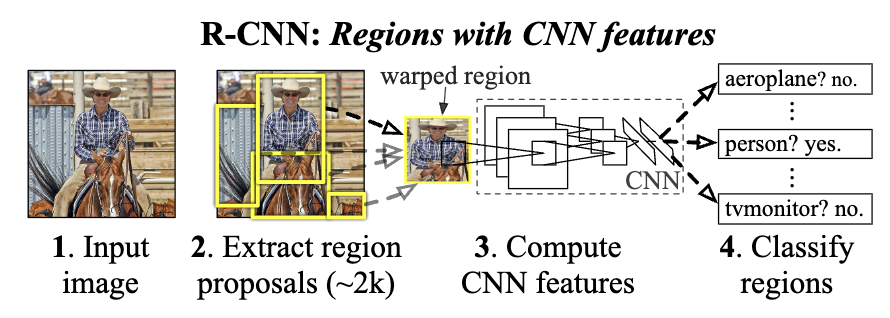

[機器/深度學習: 物件偵測 Non-Maximum Suppression (NMS)](https://chih-sheng-huang821.medium.com/%E6%A9%9F%E5%99%A8-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E7%89%A9%E4%BB%B6%E5%81%B5%E6%B8%AC-non-maximum-suppression-nms-aa70c45adffa)

ref: https://www.kaggle.com/code/aravindanr22052001/tutorial-1-rcnn-clearly-explained

ref: https://www.kaggle.com/code/ggsri123/objectdetection-using-rcnn/notebook